# Setup

## Imports

In [1]:
from fastai.imports import *
from fastai.structured import *

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
import feather

from contextlib import contextmanager

## Define Useful Features

In [4]:
jtplot_style()

In [5]:
def _make(self):
    self.mkdir(parents=True, exist_ok=True)
    return self
Path.make = _make

In [6]:
COMPETITION = 'bluebook-for-bulldozers'

In [7]:
DIR_DATA = (DIR_KAGGLE / COMPETITION).make()

In [8]:
DIR_CHECKPOINTS = (DIR_NB / 'Checkpoints' / COMPETITION).make()

In [9]:
@contextmanager
def workdir(path):
    path_cwd = os.getcwd()
    os.chdir(path)

    yield

    os.chdir(path_cwd)

In [10]:
def _show(self):
    max_columns = len(self.columns) if hasattr(self, 'columns') else 2
    with pd.option_context("display.max_rows", len(self),
                           "display.max_columns", max_columns): 
            display(self)

pd.DataFrame.show = _show
pd.core.series.Series.show = _show

In [11]:
_rmse = lambda input_, target: ((input_ - target) ** 2).mean()

In [12]:
def _eval(self, x, y):
    return self.score(x, y), _rmse(self.predict(x), y)

RandomForestRegressor.eval = _eval

In [13]:
def split_val(*args, frac):
    assert np.std([len(a) for a in args]) == 0

    n_train = int(len(args[0]) * (1- frac))
    return [a[:n_train] for a in args], [a[n_train:] for a in args]

In [14]:
def _print_scores(model):
    print('Training - r^2, RMSE:', model.eval(x, y))
    print('Validation - r^2, RMSE:', model.eval(x_val, y_val))
    if hasattr(model, 'oob_score_'): print('oob:', model.oob_score_)

In [15]:
def train_model(model):
    model.fit(x, y)
    _print_scores(model)
    return model

## Load and Preprocess Data

In [16]:
assert not (DIR_DATA / 'train.ft').exists(), "Data already preprocessed"

In [17]:
if not (DIR_DATA / 'Train.csv').exists():
    with workdir(DIR_DATA):
        !kaggle competitions download -c {COMPETITION} -f Train.7z
        !7z x Train.7z
        !rm Train.7z

Get Data

In [19]:
data = pd.read_csv(DIR_DATA / 'Train.csv', low_memory=False, parse_dates=['saledate'])
data.head().T.show()

0  \
SalesID                                                    1139246   
SalePrice                                                    66000   
MachineID                                                   999089   
ModelID                                                       3157   
datasource                                                     121   
auctioneerID                                                     3   
YearMade                                                      2004   
MachineHoursCurrentMeter                                        68   
UsageBand                                                      Low   
saledate                                       2006-11-16 00:00:00   
fiModelDesc                                                   521D   
fiBaseModel                                                    521   
fiSecondaryDesc                                                  D   
fiModelSeries                                                  NaN   
fiModelDescriptor                                              NaN   
ProductSize                                                    NaN   
fiProductClassDesc        Wheel Loader - 110.0 to 120.0 Horsepower   
state                                                      Alabama   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                          None or Unspecified   
Pad_Type                                                       NaN   
Ride_Control                                   None or Unspecified   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                      None or Unspecified   
Coupler                                        None or Unspecified   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                                 1  \
SalesID                                                    1139248   
SalePrice                                                    57000   
MachineID                                                   117657   
Mode

See the Stats

In [20]:
data.describe(include='all').T.show()

count unique  \
SalesID                   401125    NaN   
SalePrice                 401125    NaN   
MachineID                 401125    NaN   
ModelID                   401125    NaN   
datasource                401125    NaN   
auctioneerID              380989    NaN   
YearMade                  401125    NaN   
MachineHoursCurrentMeter  142765    NaN   
UsageBand                  69639      3   
saledate                  401125   3919   
fiModelDesc               401125   4999   
fiBaseModel               401125   1950   
fiSecondaryDesc           263934    175   
fiModelSeries              56908    122   
fiModelDescriptor          71919    139   
ProductSize               190350      6   
fiProductClassDesc        401125     74   
state                     401125     53   
ProductGroup              401125      6   
ProductGroupDesc          401125      6   
Drive_System              104361      4   
Enclosure                 400800      6   
Forks                     192077      2   
Pad_Type                   79134      4   
Ride_Control              148606      3   
Stick                      79134      2   
Transmission              183230      8   
Turbocharged               79134      2   
Blade_Extension            25219      2   
Blade_Width                25219      6   
Enclosure_Type             25219      3   
Engine_Horsepower          25219      2   
Hydraulics                320570     12   
Pushblock                  25219      2   
Ripper                    104137      4   
Scarifier                  25230      2   
Tip_Control                25219      3   
Tire_Size                  94718     17   
Coupler                   213952      3   
Coupler_System             43458      2   
Grouser_Tracks             43362      2   
Hydraulics_Flow            43362      3   
Track_Type                 99153      2   
Undercarriage_Pad_Width    99872     19   
Stick_Length               99218     29   
Thumb                      99288      3   
Pattern_Changer            99218      3   
Grouser_Type               99153      3   
Backhoe_Mounting           78672      2   
Blade_Type                 79833     10   
Travel_Controls            79834      7   
Differential_Type          69411      4   
Steering_Controls          69369      5   

                                                                        top  \
SalesID                                                                 NaN   
SalePrice                                                               NaN   
MachineID                                                               NaN   
ModelID                                                                 NaN   
datasource                                                              NaN   
auctioneerID                                                            NaN   
YearMade                                                                NaN   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                            Medium   
saledate                                                2009-02-16 00:00:00   
fiModelDesc                                                            310G   
fiBaseModel                                                             580   
fiSecondaryDesc                                                           C   
fiModelSeries                                                            II   
fiModelDescriptor                                                         L   
ProductSize                                                          Medium   
fiProductClassDesc        Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...   
state                                                               Florida   
ProductGroup                                                            TEX   
ProductGroupDesc                                           Track Excavators   
Drive_System                                 

The sales run from 17/1/1989 to 30/12/2011.

Since we need to predict the future, it would be wise to order by date so that we can take the validation set split off from the tail.

In [20]:
data = data.sort_values('saledate').reset_index(drop=True)

In [21]:
data.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1646770       9500    1126363     8434         132          18.0      1974   
1  1404019      24000    1169900     7110         132          99.0      1986   
2  1415646      35000    1262088     3357         132          99.0      1975   
3  1596358      19000    1433229     8247         132          99.0      1978   
4  1821514      14000    1194089    10150         132          99.0      1980   

   MachineHoursCurrentMeter UsageBand   saledate        ...         \
0                       NaN       NaN 1989-01-17        ...          
1                       NaN       NaN 1989-01-31        ...          
2                       NaN       NaN 1989-01-31        ...          
3                       NaN       NaN 1989-01-31        ...          
4                       NaN       NaN 1989-01-31        ...          

  Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer Grouser_Type  \
0                     NaN          NaN   NaN             NaN          NaN   
1                     NaN          NaN   NaN             NaN          NaN   
2                     NaN          NaN   NaN             NaN          NaN   
3                     NaN          NaN   NaN             NaN          NaN   
4                     NaN          NaN   NaN             NaN          NaN   

      Backhoe_Mounting Blade_Type      Travel_Controls Differential_Type  \
0  None or Unspecified   Straight  None or Unspecified               NaN   
1                  NaN        NaN                  NaN               NaN   
2                  NaN        NaN                  NaN               NaN   
3                  NaN        NaN                  NaN          Standard   
4                  NaN        NaN                  NaN          Standard   

  Steering_Controls  
0               NaN  
1               NaN  
2               NaN  
3      Conventional  
4      Conventional  

[5 rows x 53 columns]

### Preprocess

Since the competition asks for the log RMSE...

In [22]:
data.SalePrice = np.log(data.SalePrice)

Extract Features from the saledate Column

In [23]:
add_datepart(data, 'saledate')
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


Make string data categorical

In [24]:
train_cats(data)

In [25]:
data.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Better for random forests that the ordering makes logical sense

In [26]:
data.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Show fraction of null values

In [27]:
(data.isnull().sum().sort_values(ascending=False) / len(data)).show()

Pushblock                   0.937129
Blade_Extension             0.937129
Blade_Width                 0.937129
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Tip_Control                 0.937129
Scarifier                   0.937102
Grouser_Tracks              0.891899
Hydraulics_Flow             0.891899
Coupler_System              0.891660
fiModelSeries               0.858129
Steering_Controls           0.827064
Differential_Type           0.826959
UsageBand                   0.826391
fiModelDescriptor           0.820707
Backhoe_Mounting            0.803872
Pad_Type                    0.802720
Stick                       0.802720
Turbocharged                0.802720
Blade_Type                  0.800977
Travel_Controls             0.800975
Tire_Size                   0.763869
Track_Type                  0.752813
Grouser_Type                0.752813
Stick_Length                0.752651
Pattern_Changer             0.752651
Thumb                       0.752476
U

In [28]:
data.to_feather(DIR_DATA / 'train.ft')

In [29]:
!rm {DIR_DATA / 'Train.csv'}

## Create Training Set

In [30]:
if 'data' not in globals().keys(): data = feather.read_dataframe(DIR_DATA / 'train.ft')

Handle NAs, turn categorical values into numbers and split the dependent variable

In [31]:
x, y, nas = proc_df(data, 'SalePrice')

In [32]:
x.head().T.show()

0          1          2          3  \
SalesID                        1646770    1404019    1415646    1596358   
MachineID                      1126363    1169900    1262088    1433229   
ModelID                           8434       7110       3357       8247   
datasource                         132        132        132        132   
auctioneerID                        18         99         99         99   
YearMade                          1974       1986       1975       1978   
MachineHoursCurrentMeter             0          0          0          0   
UsageBand                            0          0          0          0   
fiModelDesc                       4537        735         82       1158   
fiBaseModel                       1735        243         19        349   
fiSecondaryDesc                      0          0         57          0   
fiModelSeries                        0          0          0          0   
fiModelDescriptor                    0          0          0          0   
ProductSize                          4          0          0          4   
fiProductClassDesc                  47          2         31         63   
state                               44          9          9          9   
ProductGroup                         5          1          2          6   
ProductGroupDesc                     5          1          2          6   
Drive_System                         0          4          3          0   
Enclosure                            6          1          6          6   
Forks                                0          1          0          1   
Pad_Type                             0          2          0          0   
Ride_Control                         0          1          0          2   
Stick                                0          2          0          0   
Transmission                         3          8          5          0   
Turbocharged                         0          1          0          0   
Blade_Extension                      0          0          1          0   
Blade_Width                          0          0          1          0   
Enclosure_Type                       0          0          3          0   
Engine_Horsepower                    0          0          1          0   
Hydraulics                           1          0          5          1   
Pushblock                            0          0          1          0   
Ripper                               2          0          2          0   
Scarifier                            0          0          2          0   
Tip_Control                          0          0          2          0   
Tire_Size                            0          0          4         17   
Coupler                              0          0          0          3   
Coupler_System                       0          0          0          0   
Grouser_Tracks                       0          0          0          0   
Hydraulics_Flow                      0          0          0          0   
Track_Type                           0          0          0          0   
Undercarriage_Pad_Width              0          0          0          0   
Stick_Length                         0          0          0          0   
Thumb                                0          0          0          0   
Pattern_Changer                      0          0          0          0   
Grouser_Type                         0          0          0          0   
Backhoe_Mounting                     1          0          0          0   
Blade_Type                           8          0          0          0   
Travel_Controls                      6          0          0          0   
Differential_Type                    0          0          0          4   
Steering_Controls                    0          0          0          2   
saleYear                          1989       1989       1989       1989   
saleMonth                            1          1          1  

# Train Model

In [25]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1)

In [26]:
model.fit(x, y)
print('r^2, RMSE:', model.eval(x, y))

r^2, RMSE: (0.9831838033335615, 0.00809041892578895)


## Split into Validation Set

In [19]:
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

In [20]:
model = train_model(RandomForestRegressor(n_estimators=10, n_jobs=-1))

Training - r^2, RMSE: (0.9828992707334833, 0.008182735498924114)
Validation - r^2, RMSE: (0.8917688910530368, 0.060512958512293866)


## Use a sample set

In [21]:
x, y, nas = proc_df(data, 'SalePrice', subset=30000, na_dict=nas)

In [23]:
model = train_model(RandomForestRegressor(n_estimators=10, n_jobs=-1))

Training - r^2, RMSE: (0.973333114452605, 0.012724561990960524)
Validation - r^2, RMSE: (0.8701580667422684, 0.0725957591752237)
CPU times: user 4.89 s, sys: 20 ms, total: 4.91 s
Wall time: 4.92 s


# Decision Trees

## Single Tree

In [24]:
model = train_model(RandomForestRegressor(1, max_depth=3, bootstrap=False, n_jobs=-1))

Training - r^2, RMSE: (0.39114820243007375, 0.2905240819261352)
Validation - r^2, RMSE: (0.4254331167197595, 0.32124536382153324)


In [27]:
draw_tree(model.estimators_[0], x, precision=3)

In [28]:
model = train_model(RandomForestRegressor(1, bootstrap=False, n_jobs=-1))

Training - r^2, RMSE: (1.0, 5.048709793414476e-33)
Validation - r^2, RMSE: (0.7676610286277737, 0.1299027485926083)


## Bagging

In [29]:
model = train_model(RandomForestRegressor(10, bootstrap=False, n_jobs=-1))

Training - r^2, RMSE: (1.0, 2.136656057154618e-30)
Validation - r^2, RMSE: (0.7814424456288168, 0.1221974379537475)


With Bootstrapping

In [30]:
model = train_model(RandomForestRegressor(10, n_jobs=-1))

Training - r^2, RMSE: (0.9720379413288505, 0.013342576069618103)
Validation - r^2, RMSE: (0.8650300435717055, 0.07546288172796785)


In [31]:
preds = np.stack([tree.predict(x_val) for tree in model.estimators_])
preds[:, 0], np.mean(preds[:, 0]), y_val[0]

(array([9.79813, 8.92266, 9.90349, 8.92266, 9.01797, 8.92266, 9.07681, 9.74097, 9.13238, 8.92266]),
 9.236037269973725,
 9.104979856318357)

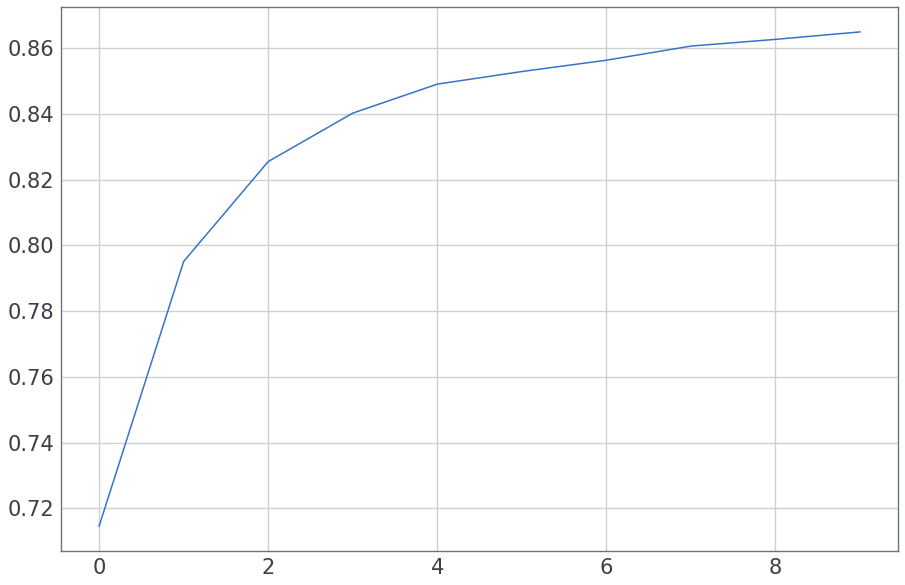

In [36]:
plot([metrics.r2_score(y_val, np.mean(preds[:i+1], axis=0)) for i in range(10)])

### More Trees

In [37]:
model = train_model(RandomForestRegressor(20, n_jobs=-1))

Training - r^2, RMSE: (0.9776289426074527, 0.010674733878797906)
Validation - r^2, RMSE: (0.8740557799476826, 0.07041651367190337)


In [38]:
model = train_model(RandomForestRegressor(40, n_jobs=-1))

Training - r^2, RMSE: (0.9798537179057311, 0.009613144172396402)
Validation - r^2, RMSE: (0.8790501266758941, 0.06762413078586663)


In [39]:
model = train_model(RandomForestRegressor(80, n_jobs=-1))

Training - r^2, RMSE: (0.980774545511417, 0.00917375548072813)
Validation - r^2, RMSE: (0.8819770622362902, 0.06598765554452728)


## Out-of-Bag Error

In [40]:
model = train_model(RandomForestRegressor(40, n_jobs=-1, oob_score=True))

Training - r^2, RMSE: (0.9797277349468135, 0.009673259102867099)
Validation - r^2, RMSE: (0.8792475609189782, 0.06751374357578536)
oob: 0.8545616399191518


## Reduce Overfitting

### Subsampling

In [41]:
x, y, nas = proc_df(data, 'SalePrice')
(x, y), (x_val, y_val) = split_val(x, y, frac=0.03)

In [42]:
set_rf_samples(20000)

In [43]:
model = train_model(RandomForestRegressor(10, n_jobs=-1, oob_score=True))

Training - r^2, RMSE: (0.8795880962687463, 0.05761735326013152)
Validation - r^2, RMSE: (0.860172335051713, 0.07817886899812677)
oob: 0.8669408273651418


In [44]:
model = train_model(RandomForestRegressor(40, n_jobs=-1, oob_score=True))

Training - r^2, RMSE: (0.8924079613738382, 0.05148302041081548)
Validation - r^2, RMSE: (0.8771473408070789, 0.06868799498773691)
oob: 0.8808862159303755


### Other Hyperparamers

In [45]:
reset_rf_samples()

In [46]:
model = train_model(RandomForestRegressor(1, n_jobs=-1))

Training - r^2, RMSE: (0.9315197280250573, 0.03276795648490392)
Validation - r^2, RMSE: (0.7631189612531158, 0.13244225814098975)


In [47]:
model = train_model(RandomForestRegressor(40, n_jobs=-1, oob_score=True))

Training - r^2, RMSE: (0.9871529998589806, 0.006147317021995886)
Validation - r^2, RMSE: (0.8982382849264624, 0.05689586388145041)
oob: 0.9082907023797605


In [48]:
model = train_model(RandomForestRegressor(40, min_samples_leaf=3,
                                          n_jobs=-1, oob_score=True))

Training - r^2, RMSE: (0.9722878050492925, 0.013260344505907162)
Validation - r^2, RMSE: (0.9021923863188243, 0.054685091250203995)
oob: 0.9082818111346086


In [49]:
model = train_model(RandomForestRegressor(n_estimators=40,  min_samples_leaf=3, n_jobs=-1,
                                          max_features='sqrt', oob_score=True))

Training - r^2, RMSE: (0.9482263107049101, 0.024773820970004364)
Validation - r^2, RMSE: (0.879857496227669, 0.06717272341634055)
oob: 0.895197312530383
